# Objetivo do projeto:
## Realizar uma análise de sentimento nos tweets do estado de minas gerais.

#IMPORTS

In [1]:
# Bibliotecas utilizadas
import nltk
import re

import pandas as pd
import numpy  as np

from nltk                            import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes             import MultinomialNB
from sklearn                         import svm
from sklearn                         import metrics
from sklearn.model_selection         import cross_val_predict
from nltk.tokenize                   import TweetTokenizer
from sklearn.pipeline                import Pipeline

##Help functions

In [2]:
# Funçção que aplica transformações nas frases com negação
def negation(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))


# Função que calculas as métricas de avaliação dos modelos de classificação
def model_performance(modelo, tweets, classes,model_name):
  resultados = cross_val_predict(modelo, tweets, classes, cv=10)
  return   pd.DataFrame({   'ModelName':model_name,                                     
                            'AccuracyCV': np.round(metrics.accuracy_score(classes,resultados),2).astype(str)  
                        },index=[0])

##Loading data

In [3]:
df = pd.read_csv('/content/Tweets_Mg.csv', encoding='utf-8')
df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#DESCRIPTION OF DATA

##Rename columns

In [4]:
# Renomeando a colunas de classificação
columns={'Classificacao':'Classification'}
df.rename(columns=columns,inplace=True)

# Alterando as classificações para o Português
df['Classification']=df['Classification'].apply(lambda x: 'Positive' if x=='Positivo' else 
                                                          'Neutral' if x=='Neutro' else 
                                                          'Negative' if x=='Negativo' else x)

##Number of classes


In [5]:
df['Classification'].value_counts()

Positive    3300
Neutral     2453
Negative    2446
Name: Classification, dtype: int64

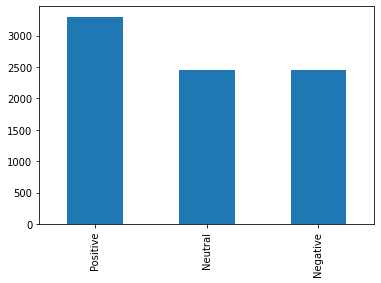

In [6]:
# Quantidade de classes da variavel resposta
%matplotlib inline
df['Classification'].value_counts().plot(kind='bar')

##Data Dimensions

In [7]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of cols: {}'.format(df.shape[1]))

Number of rows: 8199
Number of cols: 26


#DATA PREPARATION

##Removing duplicate lines

In [8]:
# Retirando os registros duplicados da variavel 'Text'
df.drop_duplicates(['Text'], inplace=True)
df.Text.count()

5765

In [9]:
# Deletando as linhas
num_lines=df.shape[0]
num_lines_delete=num_lines-df.shape[0]
print('Number of deleted lines: {}'.format(num_lines_delete))

Number of deleted lines: 0


##Peparating the classes

In [10]:
tweets = df['Text']
classes = df['Classification']

##TweetTokenizer

In [11]:
# Instanciando o tokenizer
tweet_tokenizer = TweetTokenizer()

#MACHINE LEARNING MODELS

In [12]:
# CRIANDO OS PIPELINES DOS MODELOS DE CLASSIFICAÇÃO
# MultinomialNB
pipeline_MultinomialNB = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

# MultinomialNB negation
pipeline_negation = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: negation(text))),
  ('classifier', MultinomialNB())
])

# SVC
pipeline_svm = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

# SVC negation
pipeline_svm_negation = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: negation(text))),
  ('classifier', svm.SVC(kernel='linear'))
])

## Performance

In [13]:
pipeline_MultinomialNB_result=   model_performance(pipeline_MultinomialNB,  tweets, classes,'pipeline_MultinomialNB')
pipeline_negation_result=        model_performance(pipeline_negation,       tweets, classes,'pipeline_negation')
pipeline_svm_result=             model_performance(pipeline_svm,            tweets, classes,'pipeline_svm')
pipeline_svm_negation_result=    model_performance(pipeline_svm_negation,   tweets, classes,'pipeline_svm_negation')

modelling_results_cv=pd.concat([         pipeline_MultinomialNB_result,
                                         pipeline_negation_result,
                                         pipeline_svm_result,
                                         pipeline_svm_negation_result],axis=0)

modelling_results_cv.sort_values('AccuracyCV',ascending=False)

,ModelName,AccuracyCV
0,pipeline_svm,0.89
0,pipeline_MultinomialNB,0.87
0,pipeline_svm_negation,0.77
0,pipeline_negation,0.68
